In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pingouin as pg
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

In [2]:
# load
datapath = '../csv/tdcs.csv'
data = pd.read_csv(datapath)

# ptm params, and make it long
ptm_df = data[['SID','FCZ_Na','FCZ_Nm','FCZ_Af','PZ_Na','PZ_Nm','PZ_Af','SH_Na','SH_Nm','SH_Af']]
ptm_long = pd.wide_to_long(df=ptm_df, stubnames=['FCZ', 'PZ', 'SH'], i='SID', j='param', sep='_', suffix=r'\w+')
ptm_long = ptm_long.reset_index()
ptm_long = pd.melt(ptm_long, id_vars=['SID', 'param'], var_name='loc', value_name='estimates')

# get difference and make it long
diff_df = data[['SID','FrSh_Na','FrSh_Nm','FrSh_Af','PSh_Na','PSh_Nm','PSh_Af']]
diff_long = pd.wide_to_long(df=diff_df, stubnames=['FrSh', 'PSh'], i='SID', j='param', sep='_', suffix=r'\w+')
diff_long = diff_long.reset_index()
diff_long = pd.melt(diff_long, id_vars=['SID', 'param'], var_name='loc', value_name='difference')

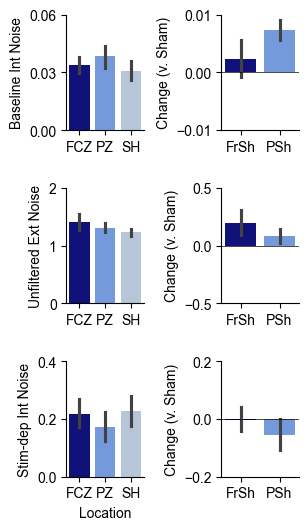

In [16]:
# plot

f, axs = plt.subplots(3, 2, sharey=False)
f.set_size_inches(3,6)
plt.subplots_adjust(wspace=1, hspace=0.5)
colors = ['darkblue', 'cornflowerblue', 'lightsteelblue']

sns.barplot(data=ptm_long[ptm_long['param']=='Na'], x='loc', y='estimates', hue='loc', legend=False,
            errorbar=('ci',68), ax=axs[0,0], palette=colors)
axs[0,0].set_ylabel('Baseline Int Noise')
axs[0,0].set_xlabel('')
axs[0,0].set_yticks([0, 0.03, 0.06])

sns.barplot(data=ptm_long[ptm_long['param']=='Af'], x='loc', y='estimates', hue='loc', legend=False, 
            errorbar=('ci',68), ax=axs[1,0], palette=colors)
axs[1,0].set_ylabel('Unfiltered Ext Noise')
axs[1,0].set_xlabel('')
axs[1,0].set_yticks([0, 1, 2])

sns.barplot(data=ptm_long[ptm_long['param']=='Nm'], x='loc', y='estimates', hue='loc', legend=False, 
            errorbar=('ci',68), ax=axs[2,0], palette=colors)
axs[2,0].set_ylabel('Stim-dep Int Noise')
axs[2,0].set_xlabel('Location')
axs[2,0].set_yticks([0, 0.2, 0.4])

sns.barplot(data=diff_long[diff_long['param']=='Na'], x='loc', y='difference', hue='loc', legend=False, 
            errorbar=('ci',68), ax=axs[0,1], palette=colors[:2])
axs[0,1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('Change (v. Sham)')
axs[0,1].set_yticks([-0.01, 0, 0.01])

sns.barplot(data=diff_long[diff_long['param']=='Af'], x='loc', y='difference', hue='loc', legend=False, 
            errorbar=('ci',68), ax=axs[1,1], palette=colors[:2])
axs[1,1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axs[1,1].set_xlabel('')
axs[1,1].set_ylabel('Change (v. Sham)')
axs[1,1].set_yticks([-0.5, 0, 0.5])

sns.barplot(data=diff_long[diff_long['param']=='Nm'], x='loc', y='difference', hue='loc', legend=False, 
            errorbar=('ci',68), ax=axs[2,1], palette=colors[:2])
axs[2,1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axs[2,1].set_xlabel('')
axs[2,1].set_ylabel('Location')
axs[2,1].set_ylabel('Change (v. Sham)')
axs[2,1].set_yticks([-0.2, 0, 0.2])

sns.despine()

plt.savefig('tdcs-ptm-params.pdf', dpi=300, transparent=True, bbox_inches="tight")

# repeated measures anova (effect of location)

In [4]:
# additive noise (marginally significant)
Na_aov = pg.rm_anova(dv='estimates', within=['loc'], subject='SID', data=ptm_long[ptm_long['param']=='Na'])
Na_aov.round(5)

/Users/woonjupark/Documents/code/ptm-wm-sz/env/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,loc,2,32,3.20912,0.05368,0.0237,0.69538


In [5]:
# unfiltered external noise 
Af_aov = pg.rm_anova(dv='estimates', within=['loc'], subject='SID', data=ptm_long[ptm_long['param']=='Af'])
Af_aov.round(5)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,loc,2,32,2.36543,0.11013,0.12768,0.03443,0.73515,False,0.63973,0.03507


In [6]:
# multiplicative noise
Nm_aov = pg.rm_anova(dv='estimates', within=['loc'], subject='SID', data=ptm_long[ptm_long['param']=='Nm'])
Nm_aov.round(5)

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,loc,2,32,0.92305,0.40763,0.01749,0.80398


# t-test to see if difference is different from 0

In [7]:
# Additive noise, frontal - sham
Na_FrSh = diff_long.loc[(diff_long['param']=='Na') & (diff_long['loc']=='FrSh'), 'difference']
pg.ttest(Na_FrSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.69673,16,two-sided,0.495971,"[-0.0, 0.01]",0.168982,0.308,0.100533


In [8]:
# Additive noise, parietal - sham *
Na_PSh = diff_long.loc[(diff_long['param']=='Na') & (diff_long['loc']=='PSh'), 'difference']
pg.ttest(Na_PSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.923827,17,two-sided,0.001094,"[0.0, 0.01]",0.924855,34.603,0.958537


In [9]:
# Unfiltered external noise, frontal - sham
Af_FrSh = diff_long.loc[(diff_long['param']=='Af') & (diff_long['loc']=='FrSh'), 'difference']
pg.ttest(Af_FrSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.793241,16,two-sided,0.091857,"[-0.04, 0.44]",0.434925,0.926,0.392092


In [10]:
# Unfiltered external noise, parietal - sham
Af_PSh = diff_long.loc[(diff_long['param']=='Af') & (diff_long['loc']=='PSh'), 'difference']
pg.ttest(Af_PSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.416859,17,two-sided,0.17459,"[-0.04, 0.21]",0.333957,0.571,0.267284


In [11]:
# multiplicative noise, frontal - sham
Nm_FrSh = diff_long.loc[(diff_long['param']=='Nm') & (diff_long['loc']=='FrSh'), 'difference']
pg.ttest(Nm_FrSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.070086,16,two-sided,0.944994,"[-0.09, 0.08]",0.016998,0.25,0.050499


In [12]:
# multiplicative noise, parietal - sham
Nm_PSh = diff_long.loc[(diff_long['param']=='Nm') & (diff_long['loc']=='PSh'), 'difference']
pg.ttest(Nm_PSh, y=0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.955347,17,two-sided,0.352791,"[-0.18, 0.07]",0.225177,0.363,0.147185
